In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.cluster import KMeans

Salary Distribution

In [14]:
df = pd.read_csv("data\salaries.csv")

print("==============================================\nData Inspection\n==============================================")
print("TTL rows: ", len(df))
print("==============================================\n", df.info())
print("==============================================\n", print(f"Shape of dataset: {df.shape}"))
df.head()

Data Inspection
TTL rows:  133349
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133349 entries, 0 to 133348
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   work_year           133349 non-null  int64 
 1   experience_level    133349 non-null  object
 2   employment_type     133349 non-null  object
 3   job_title           133349 non-null  object
 4   salary              133349 non-null  int64 
 5   salary_currency     133349 non-null  object
 6   salary_in_usd       133349 non-null  int64 
 7   employee_residence  133349 non-null  object
 8   remote_ratio        133349 non-null  int64 
 9   company_location    133349 non-null  object
 10  company_size        133349 non-null  object
dtypes: int64(4), object(7)
memory usage: 11.2+ MB
 None
Shape of dataset: (133349, 11)
 None


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,SE,FT,Solutions Engineer,214000,USD,214000,US,100,US,M
1,2025,SE,FT,Solutions Engineer,136000,USD,136000,US,100,US,M
2,2025,MI,FT,Data Engineer,158800,USD,158800,AU,0,AU,M
3,2025,MI,FT,Data Engineer,139200,USD,139200,AU,0,AU,M
4,2025,EN,FT,Data Engineer,90000,USD,90000,US,0,US,M


In [15]:
print("Missing values: ", df.isnull().sum())
print("==============================================\n", f"Number of duplicates: {df.duplicated().sum()}")

df.drop_duplicates(inplace=True)

df.columns = df.columns.str.lower().str.replace(' ', '_') # Standardize column names

df.dtypes

Missing values:  work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64
 Number of duplicates: 68726


work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

In [16]:
df.describe()

for col in ['experience_level', 'employment_type', 'job_title', 'salary_currency', 'employee_residence', 'company_location', 'company_size']:
    print(f"{col}: {df[col].nunique()} unique values")

experience_level: 4 unique values


employment_type: 4 unique values
job_title: 390 unique values
salary_currency: 26 unique values
employee_residence: 102 unique values
company_location: 95 unique values
company_size: 3 unique values


###EDA

Salary Distribution

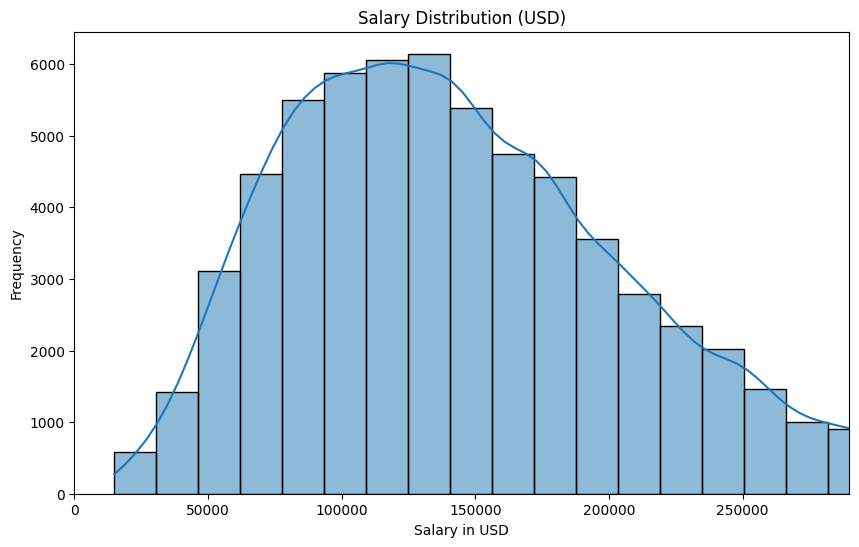

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['salary_in_usd'], bins=50, kde=True)
plt.title('Salary Distribution (USD)')
plt.xlabel('Salary in USD')
plt.ylabel('Frequency')
plt.xlim(0, df['salary_in_usd'].quantile(0.95))  # cut outliers
plt.show()


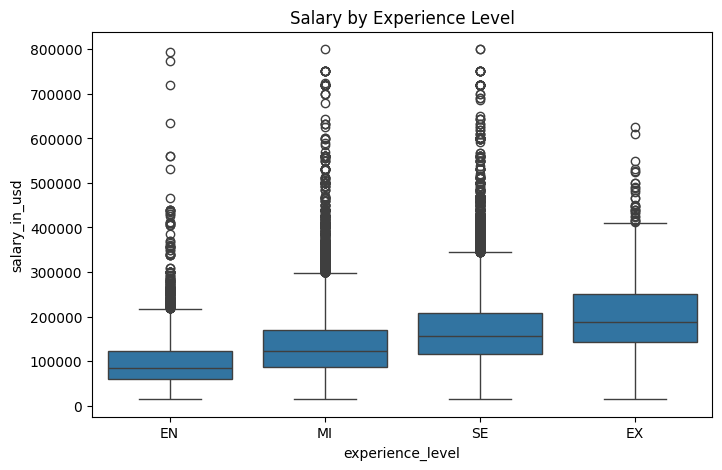

In [18]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='experience_level', y='salary_in_usd', data=df, order=['EN', 'MI', 'SE', 'EX'])
plt.title('Salary by Experience Level')
plt.show()


Top 10 Job Titles by Frequency

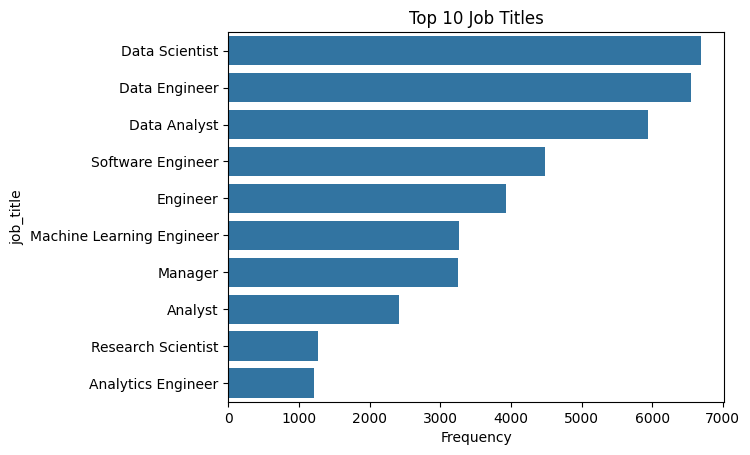

In [19]:
top_jobs = df['job_title'].value_counts().head(10)
sns.barplot(y=top_jobs.index, x=top_jobs.values)
plt.title('Top 10 Job Titles')
plt.xlabel('Frequency')
plt.show()


Remote Work vs Salary

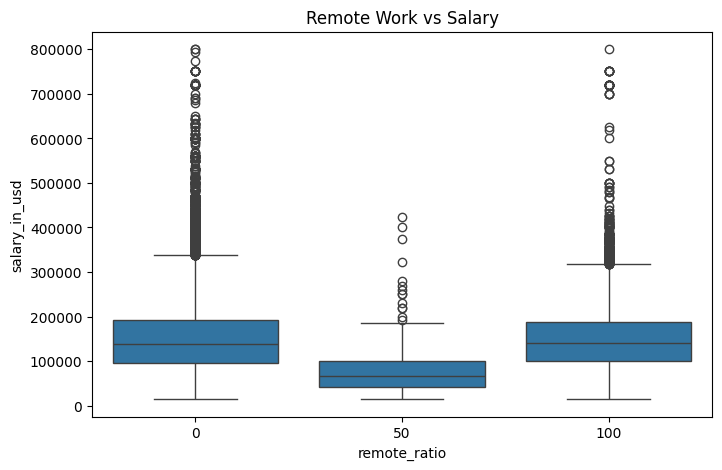

In [20]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='remote_ratio', y='salary_in_usd', data=df)
plt.title('Remote Work vs Salary')
plt.show()
